## Import Libraries

In [1]:
# Base libraries
import numpy as np 
import pandas as pd

# Data visualizaton
import matplotlib.pyplot as plt

# Images from dataset
from os import listdir
from os.path import split, splitext, isfile, join

# Data Pre-processing / Train, Validation, and Test Splits
from PIL import Image
from sklearn.model_selection import train_test_split

# Keras / model building
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Input
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.layers.core import Activation, Dropout, Lambda, Dense
from keras.optimizers import Adam
from mobilenetv2 import MuiltiMobileModel
from keras.utils import to_categorical

# Model visualization
import math
from keras.utils import plot_model
from sklearn.metrics import r2_score, classification_report
import cv2

In [2]:
dataset_folder_name = 'dataset/UTKFace/'
dataset_image_extension = '.jpg.chip.jpg'

dataset_labels = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_label_ids = {
    'race_id': dict([(race, id) for (id, race) in dataset_labels['race_id'].items()]),
    'gender_id': dict([(gender, id) for (id, gender) in dataset_labels['gender_id'].items()])
}

## Setup Environment
Define the dataset directory, and a translation dictionary for the file naming convention.

In [3]:
class DatasetParser():
    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir

    def get_info_from_filename(self, file_dir):
        # get data from filename
        filename = file_dir.split(dataset_image_extension)[0]
        age, gender, race, _ = filename.split('_')
        # return strings (rather than values) for gender, race, age, etc.
        return (
            int(age),
            dataset_labels['gender_id'][int(gender)],
            dataset_labels['race_id'][int(race)],
            self.dataset_dir + filename + dataset_image_extension
        )

    def parse_dataset(self):
        # get list of all image names
        images = [image for image in listdir(self.dataset_dir) if isfile(join(self.dataset_dir, image))]
        # get info from images
        dataset = [self.get_info_from_filename(image) for image in images]
        # add to pandas dataframe
        dataframe = pd.DataFrame(dataset)
        dataframe.columns = ['age', 'gender', 'race', 'filename']
        return dataframe

# parse dataset into pandas dataframe
dataset_parser = DatasetParser(dataset_folder_name)
dataframe = dataset_parser.parse_dataset()
dataframe.head()

,age,gender,race,filename
0,100,male,white,dataset/UTKFace/100_0_0_20170112213500903.jpg....
1,100,male,white,dataset/UTKFace/100_0_0_20170112215240346.jpg....
2,100,female,white,dataset/UTKFace/100_1_0_20170110183726390.jpg....
3,100,female,white,dataset/UTKFace/100_1_0_20170112213001988.jpg....
4,100,female,white,dataset/UTKFace/100_1_0_20170112213303693.jpg....


## Dataset Analysis
Analyzed the dataset's age, gender, and race distribution

In [4]:
def pie_plot(dataframe, title):
    # get labels and count number of each instance
    counts = dataframe.value_counts().values.tolist()
    labels = dataframe.value_counts().index.tolist()
    # plot the chart and set title / axis / etc.
    plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title(f'{title} Pie Chart')
    plt.axis('equal')
    # display chart
    plt.show()

def hist_plot(dataframe):
    # plot hist and set title / axis / etc.
    plt.hist(dataframe['age'], bins=10)
    plt.title("Age Histogram")
    plt.xlabel("Age")
    plt.ylabel("count")
    # display chart
    plt.show()

## Age Distribution
The following distribution shows the distribution of ages (both as a histogram and binned pie plot).

Bin ranges are inclusive (meaning 6 - 10 includes all images of age 6, 7, 8, 9, and 10).

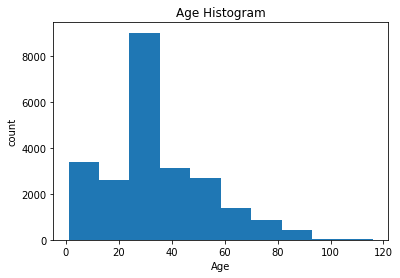

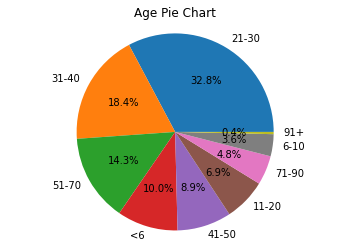

In [5]:
# plot histogram
hist_plot(dataframe)

# plot pie chart
bins = [0, 5, 10, 20, 30, 40, 50, 70, 90, np.inf]
labels = ['<6', '6-10', '11-20', '21-30', '31-40', '41-50', '51-70', '71-90', '91+']
age_binned = pd.cut(dataframe['age'], bins, labels=labels)
pie_plot(age_binned, "Age")

## Gender Distribution
The following distribution shows the distribution of gender.

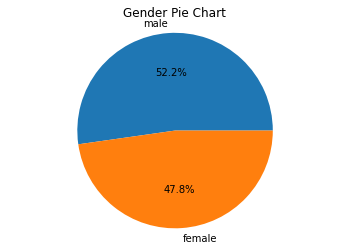

In [6]:
pie_plot(dataframe['gender'], "Gender")

## Race Distribution
The following distribution shows the distribution of all 5 races (white, black, asian, indian, and others).

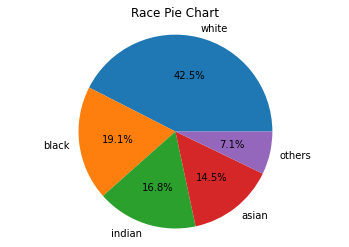

In [7]:
pie_plot(dataframe['race'], "Race")

# Data preparation

In order to input our data to our Keras multi-output model, we will create a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model.

In [8]:
class DatasetPreprocessor():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, dataframe, train_size=10, test_size=6):
        # add extra columns for gender and race ids
        dataframe['gender_id'] = dataframe['gender'].map(lambda gender: dataset_label_ids['gender_id'][gender])
        dataframe['race_id'] = dataframe['race'].map(lambda race: dataset_label_ids['race_id'][race])
        dataframe = dataframe.sample(frac=1).copy()
        self.dataframe = dataframe[:train_size + test_size]
        self.maximum_age = dataframe['age'].max()
        
    def normalize_age(self, age):
        return (age / self.maximum_age)

    def get_race_value(self, race):
        return to_categorical(race, len(dataset_labels['race_id']))

    def get_gender_value(self, gender):
        return to_categorical(gender, len(dataset_labels['gender_id']))

    def get_image(self, img_path):
        return Image.open(img_path)

    def normalize_image(self, image):
        return (np.array(image) / 255.0)
        
    def get_dataset(self):
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        for row_index, image in self.dataframe.iterrows():   
                # pre-process images
                age = self.normalize_age(image['age'])
                race = self.get_race_value(image['race_id'])
                gender = self.get_gender_value(image['gender_id'])
                im = self.normalize_image(self.get_image(image['filename']))

                # add images to list
                ages.append(age)
                races.append(race)
                genders.append(gender)
                images.append(im)
        # return x, y values
        return np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    
# pre-process dataset
dataset_processor = DatasetPreprocessor(dataframe)
x, y = dataset_processor.get_dataset()

# split dataset into test and train set
train_percentage = 0.8
x_train, y_train = x[:int(len(x) * train_percentage)], [vals[:int(len(x) * train_percentage)] for vals in y] 
x_test, y_test = x[int(len(x) * train_percentage):], [vals[int(len(x) * train_percentage):] for vals in y] 

## Build Keras Model
This builds what is essentially three separate neural network models.

The three separate models are shown below:

* 1\. Age Network
* 2\. Gender Network
* 3\. Race Network

Each model begins with a default set of layers, and is followed by a custom MobileNetV2 architecture each with separate activation functions.

In [9]:
from mobilenetv2 import MuiltiMobileModel
model = MuiltiMobileModel().build_multi_model((200, 200, 3))

<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>


## Model Visualization
Save the model structure to an image file (and display it in the cell below)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


(-0.5, 2104.5, 15438.5, -0.5)

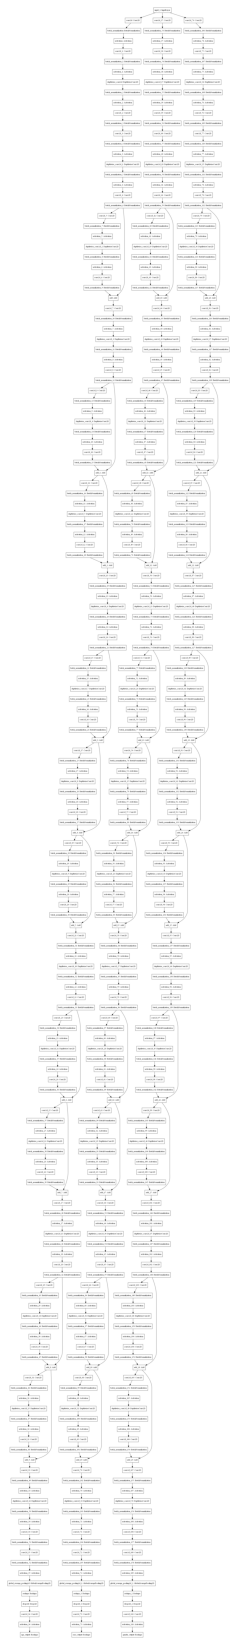

In [10]:
# save model to image
model_image_path = 'analysis/model.png'
plot_model(model, to_file=model_image_path)
# display image
img = Image.open(model_image_path)
plt.figure(figsize=(40, 30))
plt.imshow(img)
plt.axis('off')

## Model Compilation
The model uses an Adam optimizer with a learning rate of 0.0001 and a decay equal to the learning rate divided by the number of epochs. The age, gender, and race use mean-squared error, binary cross-entropy, and categorical cross-entropy loss functions respectively. This was chosen because

In [11]:
learning_rate = 0.0001
epochs = 3

optimizer = tf.keras.optimizers.Adam(
    lr=learning_rate,
    decay=0.0001 / epochs
)

loss = {
    'age_output': 'mse',
    'gender_output': 'binary_crossentropy',
    'race_output': 'categorical_crossentropy'
}

loss_weights = {
    'age_output': 4., 
    'gender_output': 0.1,
    'race_output': 1.5
}

metrics = {
    'age_output': 'mae', 
    'gender_output': 'accuracy',
    'race_output': 'accuracy'
}

model.compile(
    optimizer=optimizer, 
    loss=loss,
    loss_weights=loss_weights,
    metrics=metrics
)

## Model Training
The model below is trained using 10-fold cross validation.

In [12]:
# callback for saving the model
callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

# storing history (for graphing)
histories = []
kf = KFold(n_splits=2)

# 10-fold cross validation
for train_index, test_index in kf.split(x_train):
    history = model.fit(
        x=x[train_index],
        y=(y_train[0][train_index], y_train[1][train_index], y_train[2][train_index]),
        steps_per_epoch=len(train_index),
        epochs=epochs,
        validation_data=(x[test_index], (y_train[0][test_index], y_train[1][test_index], y_train[2][test_index])),
        validation_steps=len(test_index)
    )
    histories.append(history.history)

Epoch 1/3
6/6 [==============================] - 43s 3s/step - loss: 3.6750 - age_output_loss: 0.2003 - race_output_loss: 1.8743 - gender_output_loss: 0.6241 - age_output_mae: 0.4114 - race_output_accuracy: 0.0000e+00 - gender_output_accuracy: 0.8405 - val_loss: 3.1876 - val_age_output_loss: 0.1792 - val_race_output_loss: 1.6008 - val_gender_output_loss: 0.6948 - val_age_output_mae: 0.3852 - val_race_output_accuracy: 0.0000e+00 - val_gender_output_accuracy: 0.3333
Epoch 2/3
6/6 [==============================] - 4s 751ms/step - loss: 4.3379 - age_output_loss: 0.2443 - race_output_loss: 2.2029 - gender_output_loss: 0.5652 - age_output_mae: 0.3969 - race_output_accuracy: 0.1119 - gender_output_accuracy: 0.8405 - val_loss: 3.1438 - val_age_output_loss: 0.1723 - val_race_output_loss: 1.5899 - val_gender_output_loss: 0.6968 - val_age_output_mae: 0.3767 - val_race_output_accuracy: 0.8333 - val_gender_output_accuracy: 0.3333
Epoch 3/3
6/6 [==============================] - 4s 632ms/step - los

##  Save & Load Model
By saving the model as a checkpoint, it is able to be tested and run on various images without incurring the ~8 hour training period.

In [201]:
if (Model is not None):
    model.save('models')

model = keras.models.load_model('models')

KeyboardInterrupt: 

## Training Analysis
Used to parse and average out training results

In [13]:
def get_history_average(key):
    return sum([np.array(history[key]) for history in histories]) / len(histories)

## Race Accuracy

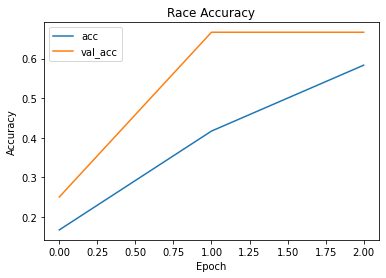

In [14]:
plt.plot(get_history_average("race_output_accuracy"), label="acc")
plt.plot(get_history_average("val_race_output_accuracy"), label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Race Accuracy")
plt.legend()
plt.show()

## Gender Accuracy

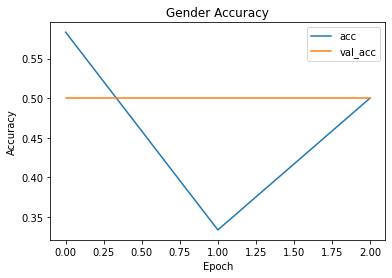

In [15]:
plt.plot(get_history_average("gender_output_accuracy"), label="acc")
plt.plot(get_history_average("val_gender_output_accuracy"), label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Gender Accuracy")
plt.legend()
plt.show()

## Age Mean Absolute Error

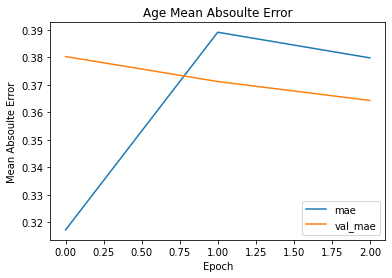

In [16]:
plt.plot(get_history_average("age_output_mae"), label="mae")
plt.plot(get_history_average("val_age_output_mae"), label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("Mean Absoulte Error")
plt.title("Age Mean Absoulte Error")
plt.legend()
plt.show()

## Overall Loss

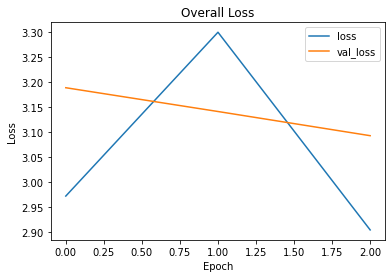

In [17]:
plt.plot(get_history_average("loss"), label="loss")
plt.plot(get_history_average("val_loss"), label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Overall Loss")
plt.legend()
plt.show()

## Evaluation
Now that the model has been trained (or loaded in), the test set can then be classified. 

In [18]:
# predict values
age_pred, race_pred, gender_pred = model.predict(x_test)
# go through test images values
images, age_true, race_true, gender_true = [], [], [], []
for i in range(len(x_test)):
    # get image and labels from batch
    image = x_test[i]
    # add values to list
    images.extend(image)
    age_true.extend([y_train[0][i]])
    race_true.extend([y_train[1][i]])
    gender_true.extend([y_train[2][i]])

# convert values to numpy arrays
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

# take best predictions (from one-hot encodings)
race_true, race_pred = race_true.argmax(axis=-1), race_pred.argmax(axis=-1)
gender_true, gender_pred = gender_true.argmax(axis=-1), gender_pred.argmax(axis=-1)

# re-normalize ages
age_true = age_true * 116 # data_generator.max_age
age_pred = age_pred * 116 # data_generator.max_age

print(gender_true, gender_pred)
print(race_true, race_pred)

[0 0 1 1] [1 1 1 1]
[0 0 0 3] [0 0 0 0]


## Evaluation Accuracy
Reports on the age, gender, and race classifications are all provided below.

In [19]:
age_classification = r2_score(age_true, age_pred)
print(f'Age Classification:\n{age_classification}\n')

gender_classification = classification_report(gender_true, gender_pred, target_names=dataset_label_ids['gender_id'].keys(), labels=(range(2)))
print(f'Gender Classification:\n{gender_classification}\n')

race_classification = classification_report(race_true, race_pred, target_names=dataset_label_ids['race_id'].keys(), labels=(range(5)))
print(f'Race Classification:\n{race_classification}\n')

Age Classification:
-2.27855882725574

Gender Classification:
              precision    recall  f1-score   support

        male       0.00      0.00      0.00         2
      female       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4


Race Classification:
              precision    recall  f1-score   support

       white       0.75      1.00      0.86         3
       black       0.00      0.00      0.00         0
       asian       0.00      0.00      0.00         0
      indian       0.00      0.00      0.00         1
      others       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75         4
   macro avg       0.15      0.20      0.17         4
weighted avg       0.56      0.75      0.64         4


C:\Users\micha\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classifica

## Sample Predictions
A set of n x n random prediction images are selected and displayed below (alongside their true values).

This is meant to demonstrate a brief overview into what the predicted outputs look like.

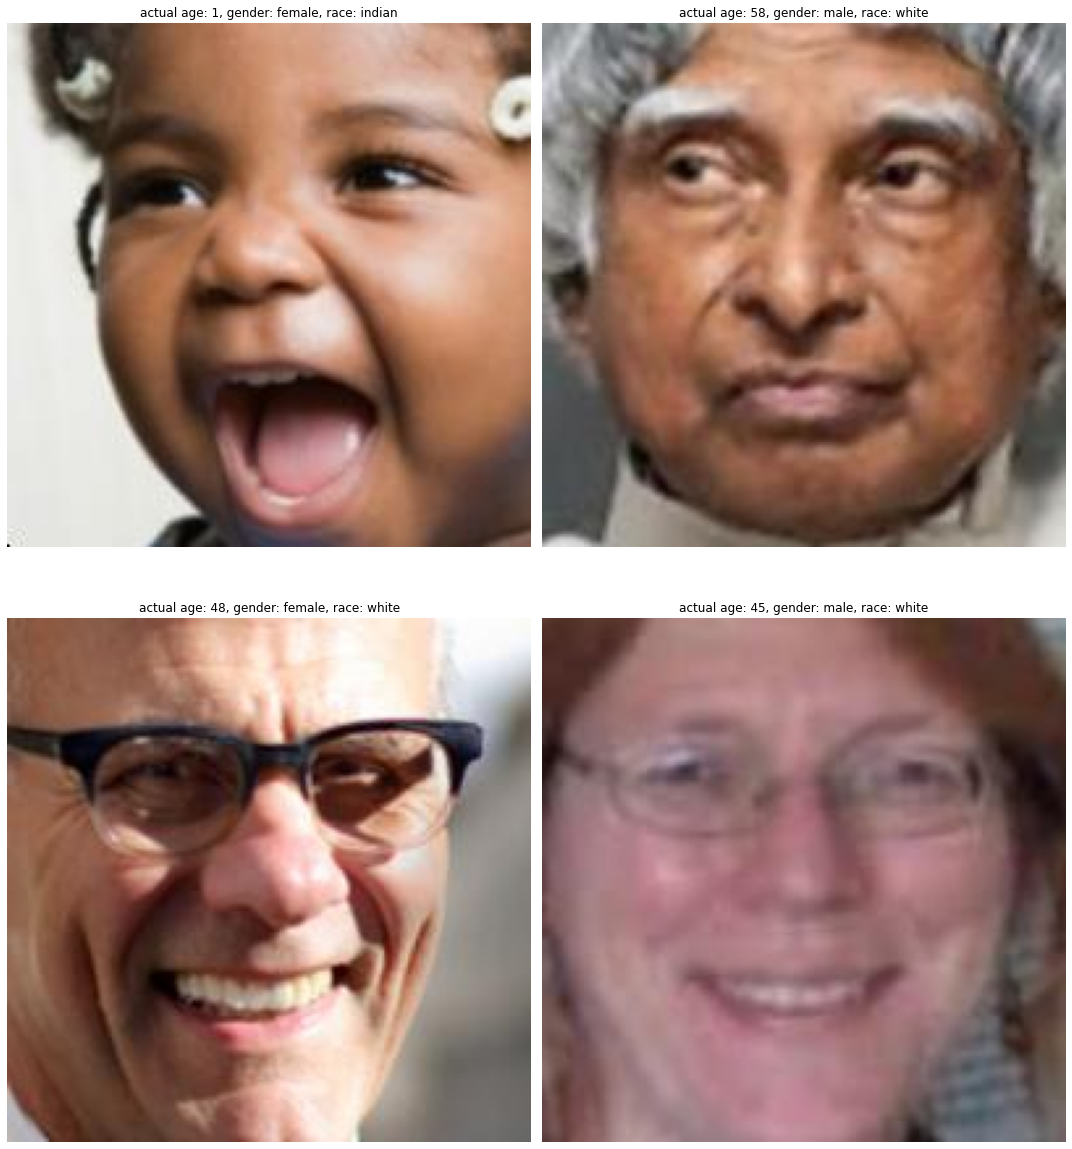

In [33]:
# put images back to rgb representation
images = np.array(images).reshape(-1, 200, 200, 3)
# create figure
num_cols, num_rows = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 17))
# get n random images
random_indices = np.random.permutation(num_cols * num_rows)
# go through images
for i, img_idx in enumerate(random_indices):
    # display image
    ax = axes.flat[i]
    ax.imshow(images[img_idx])
    # get predicted and true values
    cur_age_pred, cur_age_true = age_pred[img_idx], age_true[img_idx]
    cur_gender_pred, cur_gender_true = gender_pred[img_idx], gender_true[img_idx]
    cur_race_pred, cur_race_true = race_pred[img_idx], race_true[img_idx]
    # display almost perfectly classified images in green
    age_threshold = 10
    if cur_gender_pred == cur_gender_true and cur_race_pred == cur_race_true and abs(cur_age_pred - cur_age_true) <= age_threshold:
        ax.xaxis.label.set_color('green')
    # display completely incorrect images in red
    elif cur_gender_pred != cur_gender_true and cur_race_pred != cur_race_true and abs(cur_age_pred - cur_age_true) > age_threshold:
        ax.xaxis.label.set_color('red')
    # display predicted values against the true values
    ax.set_xlabel(f"predicted age: {int(age_pred[img_idx])}, gender: {dataset_labels['gender_id'][gender_pred[img_idx]]}, race: {dataset_labels['race_id'][race_pred[img_idx]]}")
    ax.set_title(f"actual age: {int(age_true[img_idx])}, gender: {dataset_labels['gender_id'][gender_true[img_idx]]}, race: {dataset_labels['race_id'][race_true[img_idx]]}")
    ax.set_axis_off()

# save figure
plt.tight_layout()
plt.savefig('analysis/preds.png')

## Custom Image Prediction
By uploading an image and specifying the location in the corresponding *image_path* variable,

a custom image can be analyzed and have the age, gender, and race predicted.

In [182]:
# read in image
image_path = 'image/trevor.jpg'
custom_image = np.array(Image.open(image_path))
plt.imshow(custom_image)
custom_image = custom_image.reshape((1, 200, 200, 3))
pred = model.predict(custom_image)

# display prediction
print(f"Age: {str(pred[0][0][0]*116)}")
print(f"Gender: {dataset_dict['gender_id'][pred[2][0].argmax()]}")
print(f"Race: {dataset_dict['race_id'][pred[1][0].argmax()]}")

Age: 15.065080463886261


NameError: name 'dataset_dict' is not defined